In [1]:
using GrootSim

using CSV
using DataFrames
using Dates
using Distributions
using DotEnv
DotEnv.load!()
using PyPlot
using Serialization

using PyCall
pickle = pyimport("pickle");

[ Info: Precompiling GrootSim [84197a3c-ab72-42ed-a031-1046bb28d0ec] (cache misses: include_dependency fsize change (2))


## Evaluation data params

In [2]:
basepath = ENV["EVALUATION_RESULTS_PATH"]
outpath = ENV["PAPER_RESULTS_PATH"];

In [3]:
time_window = "day"
net_models = ["hypergraph", "clique", "graph"]
# involvements = ["high_involvement", "medium_involvement", "low_involvement"]
involvements = ["medium_involvement"]
# thrs = [2, 3, 4]
thrs = [4];

In [4]:
eval_res_path = joinpath(basepath, "$(time_window)");

In [5]:
subreddits_to_eval = [
    "AskReddit",
    "bayarea",
    "California",
    "collapse",
    "news",
    "politics",
    "AskReddit_collapse",
    "AskReddit_news",
    "AskReddit_politics",
    "bayarea_news",
    "collapse_news",
    "collapse_politics",
    "AskReddit_news_politics",
    "collapse_news_politics",
    "all"
];

## Utils

In [6]:
subreddit_labels = [
    "r/AskReddit",
    "r/bayarea",
    "r/California",
    "r/collapse",
    "r/news",
    "r/politics",
    "r/AskReddit;r/collapse",
    "r/AskReddit;r/news",
    "r/AskReddit;r/politics",
    "r/bayarea;r/news",
    "r/collapse;r/news",
    "r/collapse;r/politics",
    "r/AskReddit;r/news;r/politics",
    "r/collapse;r/news;r/politics",
    "All subreddits"
];

## Eval he sorting by average he size

In [7]:
he_stats_path = joinpath(ENV["PRECOMPUTED_PARAMS_PATH"], time_window, "hyperedges_stats.csv")
he_stats_df = CSV.File(he_stats_path) |> DataFrame;

In [8]:
first(he_stats_df, 5)

Row,subreddit,type,number_hes,avg_he_number_per_interval,avg_he_size_per_interval,avg_he_size_per_interval_no_empty_intervals,avg_hes_size,median_hes_size,std_hes_size,quantile_hes_size
,String31,String15,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,AskReddit,temporal,857,0.988466,3.76754,5.0099,5.19953,4.0,4.10306,9.0
2,AskReddit,snap,2391,2.61884,3.83041,5.0031,5.19532,4.0,5.81902,8.0
3,bayarea,temporal,558,1.76025,2.67834,4.4452,4.66487,3.0,3.94357,7.0
4,bayarea,snap,329,0.36035,0.551842,4.26976,4.58967,3.0,3.36209,7.0
5,California,temporal,578,1.67052,2.57091,4.21581,4.19377,3.0,2.01738,7.0


In [9]:
# 1. filter he_stats_csv by filtering out the snap type 
he_stats_df = he_stats_df[he_stats_df.type .!= "snap", :]

# 2. sort by avg he size per simulation interval 
he_stats_df = sort(he_stats_df, :avg_he_size_per_interval);

In [10]:
he_stats_df

Row,subreddit,type,number_hes,avg_he_number_per_interval,avg_he_size_per_interval,avg_he_size_per_interval_no_empty_intervals,avg_hes_size,median_hes_size,std_hes_size,quantile_hes_size
,String31,String15,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,California,temporal,578,1.67052,2.57091,4.21581,4.19377,3.0,2.01738,7.0
2,bayarea,temporal,558,1.76025,2.67834,4.4452,4.66487,3.0,3.94357,7.0
3,bayarea_news,temporal,2945,5.11285,3.14446,4.55078,5.06961,3.0,9.11764,7.0
4,news,temporal,2405,4.68811,3.25304,4.68767,5.14802,3.0,9.78885,7.0
5,AskReddit,temporal,857,0.988466,3.76754,5.0099,5.19953,4.0,4.10306,9.0
6,AskReddit_news,temporal,1346,1.54713,3.85058,4.97772,5.13447,4.0,4.78059,8.0
7,AskReddit_politics,temporal,1313,1.51442,3.88328,4.98785,5.25819,4.0,5.20535,9.0
8,AskReddit_news_politics,temporal,1802,2.07126,3.95306,4.96272,5.19367,4.0,5.36753,8.0
9,politics,temporal,1763,2.94816,4.07745,5.26634,5.61883,3.0,10.7551,9.0


## Across nets

### Criterion C1: capacity of the model to identify a user's first opinion drift.

In [11]:
sorted_subreddits = he_stats_df.subreddit;

In [12]:
labels = ["$(row.subreddit) ($(round(row.avg_he_size_per_interval; digits = 2)))" for row in eachrow(he_stats_df)];

#### In the following, we *don't* account for the directionality of the opinion change

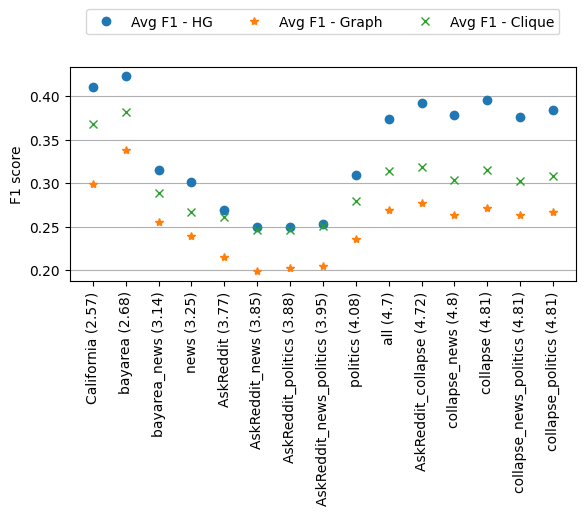

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

axs.set_xticks(range(0, length(subreddits_to_eval)-1), labels, fontsize="10", rotation=90)

f1_medians = []
f1_means = []
f1_variances = []
f1_stds = []

f1_medians_gr = []
f1_means_gr = []
f1_variances_gr = []
f1_stds_gr = []

f1_medians_cl = []
f1_means_cl = []
f1_variances_cl = []
f1_stds_cl = []

eval_func = "metrics"
ml_metric = 4 # 1: accuracy, 2: precision, 3: recall, 4: f1_score

for (thr_idx, thr) in enumerate(thrs)
    #loading evaluation data
    data = _loading_data(thr, subreddits_to_eval, eval_func, eval_res_path)
    # println((data))

    # we can move this initialization out of the loop
    # since we only consider one thr setting
    # f1_medians = []
    # f1_means = []
    # f1_stds = []

    # f1_medians_gr = []
    # f1_means_gr = []
    # f1_stds_gr = []

    # f1_medians_cl = []
    # f1_means_cl = []
    # f1_variances_cl = []

    for idx in 1:length(subreddits_to_eval)
        subreddit_name = sorted_subreddits[idx]
        subreddit_data = data[subreddit_name] 

        # println(subreddit_name)

        # F1 scores
        f1_scores = get_metrics_data(subreddit_data, "medium_involvement", "hypergraph")[ml_metric]
        
        f1_median = median(f1_scores)
        f1_mean = mean(f1_scores)
        f1_var = var(f1_scores)
        f1_std = std(f1_scores)

        push!(f1_medians, f1_median)
        push!(f1_means, f1_mean)
        push!(f1_variances, f1_var)
        push!(f1_stds, f1_std)

        # F1 scores - GR 
        f1_scores_gr = get_metrics_data(subreddit_data, "medium_involvement", "graph")[ml_metric]

        f1_median_gr = median(f1_scores_gr)
        f1_mean_gr = mean(f1_scores_gr)
        f1_var_gr = var(f1_scores_gr)
        f1_std_gr = std(f1_scores_gr)

        push!(f1_medians_gr, f1_median_gr)
        push!(f1_means_gr, f1_mean_gr)
        push!(f1_variances_gr, f1_var_gr)
        push!(f1_stds_gr, f1_std_gr)

        # F1 scores - CL
        f1_scores_cl = get_metrics_data(subreddit_data, "medium_involvement", "clique")[ml_metric]

        f1_median_cl = median(f1_scores_cl)
        f1_mean_cl = mean(f1_scores_cl)
        f1_var_cl = var(f1_scores_cl)
        f1_std_cl = std(f1_scores_cl)

        push!(f1_medians_cl, f1_median_cl)
        push!(f1_means_cl, f1_mean_cl)
        push!(f1_variances_cl, f1_var_cl)
        push!(f1_stds_cl, f1_std_cl)
    end # end over subreddits

    # ylim 
    #axs.set_ylim([0, 0.5])

    # ygrid
    axs.grid(axis="y")

    # println(f1_medians_cl)
    # println(f1_variances_cl)
    
    axs.plot(f1_means, label="Avg F1 - HG", marker="o", linestyle="None")
    # axs.errorbar(
    #     collect(range(0, length(subreddits_to_eval)-1)), 
    #     f1_medians, 
    #     yerr=f1_variances, 
    #     label="Median F1 - HG", 
    #     marker="o", 
    #     linestyle="None"
    # )

    # axs[thr_idx].plot(f1_means, label="Mean F1", marker="x", linestyle="None")

    axs.plot(f1_means_gr, label="Avg F1 - Graph", marker="*", linestyle="None")
    # axs[thr_idx].plot(f1_means_gr, label="Mean F1 - Graph", marker="*", linestyle="None")

    axs.plot(f1_means_cl, label="Avg F1 - Clique", marker="x", linestyle="None")
    # axs[thr_idx].plot(f1_means_cl, label="Mean F1 - Clique", marker="x", linestyle="None")

    # if thr_idx == 1
    #     axs[thr_idx].set_title("[Sorted by # of hyperedges]", fontweight="bold", fontsize="10") #F1 scores, First drift - $(thr) thresholds
    # else
    #     axs[thr_idx].set_title("$(thr) thresholds", fontweight="bold", fontsize="10")
    # end
    
    axs.set_ylabel("F1 score", fontsize="10")

    # if thr_idx == 1
    #     axs[thr_idx].set_title("[Sorted by avg hyperedge size per interval]", fontweight="bold", fontsize="10")# F1 scores, First drift - $(thr) thresholds
    # else
    #     axs[thr_idx].set_title("$(thr) thresholds", fontweight="bold", fontsize="10")
    # end

    axs.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.3))

    plt.tight_layout()

    # figname = joinpath(outpath, "stats", "TCSS:f1_scores_sorting_by_$(sorting).png")
    # plt.savefig(figname, bbox_inches="tight")
end #end over thrs

In [14]:
# store the results 
# type = "f1"

# CSV.write(joinpath(outpath, "Criterion1_$(type)_no_direction.csv"), DataFrame(
#     x = collect(1:length(subreddits_to_eval)),
#     subreddit = sorted_subreddits,
#     avg_f1_hg = f1_means,
#     median_f1_hg = f1_medians,
#     variance_f1_hg = f1_variances,
#     std_f1_hg = f1_stds,
#     avg_f1_gr = f1_means_gr,
#     median_f1_gr = f1_medians_gr,
#     variance_f1_gr = f1_variances_gr,
#     std_f1_gr = f1_stds_gr,
#     avg_f1_cl = f1_means_cl,
#     median_f1_cl = f1_medians_cl,
#     variance_f1_cl = f1_variances_cl,
#     std_f1_cl = f1_stds_cl
# ));

#### In the following, we account for the directionality of the opinion change

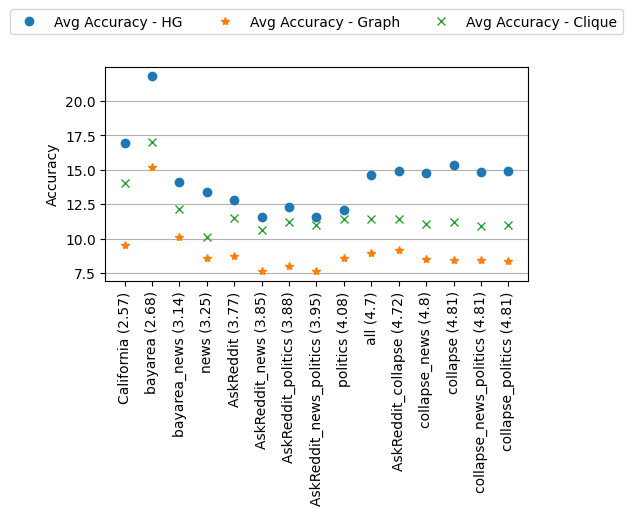

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

axs.set_xticks(range(0, length(subreddits_to_eval)-1), labels, fontsize="10", rotation=90)

acc_medians = []
acc_means = []
acc_variances = []
acc_stds = []

acc_medians_gr = []
acc_means_gr = []
acc_variances_gr = []
acc_stds_gr = []

acc_medians_cl = []
acc_means_cl = []
acc_variances_cl = []
acc_stds_cl = []

eval_func = "direction"
ml_metric = 1 # 1: accuracy, 2: precision, 3: recall, 4: f1_score

for (thr_idx, thr) in enumerate(thrs)
    #loading evaluation data
    data = _loading_data(thr, subreddits_to_eval, eval_func, eval_res_path)
    # println((data))

    # we can move this initialization out of the loop
    # since we only consider one thr setting
    # acc_medians = []
    # acc_means = []
    # acc_stds = []

    # acc_medians_gr = []
    # acc_means_gr = []
    # acc_stds_gr = []

    # acc_medians_cl = []
    # acc_means_cl = []
    # acc_variances_cl = []

    for idx in 1:length(subreddits_to_eval)
        subreddit_name = sorted_subreddits[idx]
        subreddit_data = data[subreddit_name] 

        # println(subreddit_name)

        # this values corresponds to the accuracy in practice
        acc_scores = get_metrics_data_direction(subreddit_data, "medium_involvement", "hypergraph")
        
        acc_median = median(acc_scores)
        acc_mean = mean(acc_scores)
        acc_var = var(acc_scores)
        acc_std = std(acc_scores)

        push!(acc_medians, acc_median)
        push!(acc_means, acc_mean)
        push!(acc_variances, acc_var)
        push!(acc_stds, acc_std)

        # this values corresponds to the accuracy in practice - GR
        acc_scores_gr = get_metrics_data_direction(subreddit_data, "medium_involvement", "graph")

        acc_median_gr = median(acc_scores_gr)
        acc_mean_gr = mean(acc_scores_gr)
        acc_var_gr = var(acc_scores_gr)
        acc_std_gr = std(acc_scores_gr)

        push!(acc_medians_gr, acc_median_gr)
        push!(acc_means_gr, acc_mean_gr)
        push!(acc_variances_gr, acc_var_gr)
        push!(acc_stds_gr, acc_std_gr)

        # this values corresponds to the accuracy in practice - CL
        acc_scores_cl = get_metrics_data_direction(subreddit_data, "medium_involvement", "clique")

        acc_median_cl = median(acc_scores_cl)
        acc_mean_cl = mean(acc_scores_cl)
        acc_var_cl = var(acc_scores_cl)
        acc_std_cl = std(acc_scores_cl)

        push!(acc_medians_cl, acc_median_cl)
        push!(acc_means_cl, acc_mean_cl)
        push!(acc_variances_cl, acc_var_cl)
        push!(acc_stds_cl, acc_std_cl)
    end # end over subreddits

    # ylim 
    #axs.set_ylim([0, 0.5])

    # ygrid
    axs.grid(axis="y")

    # println(f1_medians_cl)
    # println(f1_variances_cl)
    
    axs.plot(acc_means, label="Avg Accuracy - HG", marker="o", linestyle="None")
    # axs.errorbar(
    #     collect(range(0, length(subreddits_to_eval)-1)), 
    #     acc_medians, 
    #     yerr=acc_variances, 
    #     label="Median Accuracy - HG", 
    #     marker="o", 
    #     linestyle="None"
    # )

    # axs[thr_idx].plot(acc_means, label="Mean Accuracy", marker="x", linestyle="None")

    axs.plot(acc_means_gr, label="Avg Accuracy - Graph", marker="*", linestyle="None")
    # axs[thr_idx].plot(acc_means_gr, label="Mean Accuracy - Graph", marker="*", linestyle="None")

    axs.plot(acc_means_cl, label="Avg Accuracy - Clique", marker="x", linestyle="None")
    # axs[thr_idx].plot(acc_means_cl, label="Mean Accuracy - Clique", marker="x", linestyle="None")

    # if thr_idx == 1
    #     axs[thr_idx].set_title("[Sorted by # of hyperedges]", fontweight="bold", fontsize="10") #F1 scores, First drift - $(thr) thresholds
    # else
    #     axs[thr_idx].set_title("$(thr) thresholds", fontweight="bold", fontsize="10")
    # end
    
    axs.set_ylabel("Accuracy", fontsize="10")

    # if thr_idx == 1
    #     axs[thr_idx].set_title("[Sorted by avg hyperedge size per interval]", fontweight="bold", fontsize="10")# F1 scores, First drift - $(thr) thresholds
    # else
    #     axs[thr_idx].set_title("$(thr) thresholds", fontweight="bold", fontsize="10")
    # end

    axs.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.3))

    plt.tight_layout()

    # figname = joinpath(outpath, "stats", "TCSS:accuracy_scores_sorting_by_$(sorting).png")
    # plt.savefig(figname, bbox_inches="tight")
end #end over thrs

In [16]:
temp_data = acc_means .- acc_means_gr
minimum(temp_data), maximum(temp_data)

(3.5250724316475246, 7.44590671084398)

In [ ]:
# save csv 
# CSV.write(joinpath(outpath, "Criterion1_matched_drifters.csv"), DataFrame(
#     x = collect(1:length(subreddits_to_eval)),
#     subreddit = sorted_subreddits,
#     acc_medians = acc_medians,
#     acc_means = acc_means,
#     acc_vars = acc_variances,
#     acc_stds = acc_stds,
#     acc_medians_cl = acc_medians_cl,
#     acc_means_cl = acc_means_cl,
#     acc_vars_cl = acc_variances_cl,
#     acc_stds_cl = acc_stds_cl,
#     acc_medians_gr = acc_medians_gr,
#     acc_means_gr = acc_means_gr,
#     acc_vars_gr = acc_variances_gr,
#     acc_stds_gr = acc_stds_gr
# ));

## Statistical test

In [20]:
# check the statistical significance of the differences between the hg/clique/graph scores 
using HypothesisTests

thr = 4
eval_func = "direction"

data = _loading_data(thr, subreddits_to_eval, eval_func, eval_res_path)

for idx in 1:length(subreddits_to_eval)
    subreddit_name = sorted_subreddits[idx]
    subreddit_data = data[subreddit_name] 

    println(subreddit_name)

    # this values corresponds to the accuracy in practice
    acc_scores = get_metrics_data_direction(subreddit_data, "medium_involvement", "hypergraph")

    # acc scores - CL
    acc_scores_cl = get_metrics_data_direction(subreddit_data, "medium_involvement", "clique")

    # acc scores - GR 
    acc_scores_gr = get_metrics_data_direction(subreddit_data, "medium_involvement", "graph")

    scores_per_subreddit = [acc_scores, acc_scores_cl, acc_scores_gr]

    # eval the statistical significance of the differences between the scores
    # using the kruskal test 
    kw_test = KruskalWallisTest(scores_per_subreddit...)

    # if the p-value is less than 0.05, we can reject the null hypothesis
    # and conclude that there is a significant difference between the groups
    # if kw_test.p < 0.05
    #     println("Significant difference between the groups")
    # else
    #     println("No significant difference between the groups")
    # end

    println()
    println(kw_test)

    # now we test pairs of distributions 
    # using the Mann-Whitney-Wilcoxon test
    mw_test_hg_cl = MannWhitneyUTest(acc_scores, acc_scores_cl)
    mw_test_hg_gr = MannWhitneyUTest(acc_scores, acc_scores_gr)
    mw_test_cl_gr = MannWhitneyUTest(acc_scores_cl, acc_scores_gr)

    # if the p-value is less than 0.05, we can reject the null hypothesis
    # and conclude that there is a significant difference between the groups
    # if mw_test_hg_cl.p < 0.05
    #     println("Significant difference between the HG and Clique groups")
    # else
    #     println("No significant difference between the HG and Clique groups")
    # end

    println("--------------------------------------------------------\n")
    println("HG vs CL")
    println(mw_test_hg_cl)

    # if mw_test_hg_gr.p < 0.05
    #     println("Significant difference between the HG and Graph groups")
    # else
    #     println("No significant difference between the HG and Graph groups")
    # end

    println("--------------------------------------------------------\n")
    println("HG vs GR")
    println(mw_test_hg_gr)

    # if mw_test_cl_gr.p < 0.05
    #     println("Significant difference between the Clique and Graph groups")
    # else
    #     println("No significant difference between the Clique and Graph groups")
    # end

    println("--------------------------------------------------------\n")
    println("CL vs GR")
    println(mw_test_cl_gr)

    println("--------------------------------------------------------\n")
    println("--------------------------------------------------------\n")
    println("--------------------------------------------------------\n")
end # end over subreddits



California

Kruskal-Wallis rank sum test (chi-square approximation)
-------------------------------------------------------
Population details:
    parameter of interest:   Location parameters
    value under h_0:         "all equal"
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-28

Details:
    number of observation in each group: [84, 84, 84]
    χ²-statistic:                        130.087
    rank sums:                           [15617.5, 11346.0, 4914.5]
    degrees of freedom:                  2
    adjustment for ties:                 0.999967

--------------------------------------------------------

HG vs CL
Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          2.1784

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-val